# Simple Neural Architecture Search (NAS) via Random Search on a 10D Analytical Function

This notebook demonstrates an **easy, transparent** form of Neural Architecture Search (NAS) without extra libraries—just TensorFlow/Keras and a bit of Python. We:

1. Define a **10-dimensional analytical regression task** (synthetic data with noise).
2. Specify a **large search space** (depth, width, activations, optimizers, learning rates, batch sizes, normalization, dropout, etc.).
3. Use **Random Search** to sample candidate architectures and hyperparameters.
4. Train each candidate briefly and evaluate on a validation set.
5. **Select the top 10** architectures by validation performance.
6. Retrain the top models longer on train+val and evaluate on the held-out test set.

The notebook is heavily commented for a ~45' walkthrough.


## Why Random Search?
Random Search is a surprisingly strong baseline for hyperparameter/architecture tuning:
- Scales trivially with search space size.
- Parallelizable and easy to reason about.
- Often outperforms naive grid search given the same budget (because many hyperparameters are low-sensitivity).

Other simple NAS strategies to mention (not implemented here):
- **Successive Halving / Hyperband:** Early-stop poor performers aggressively.
- **Bayesian Optimization:** Model the response surface to guide sampling.
- **Evolutionary Strategies:** Mutate and select architectures over generations.

Here we focus on Random Search for **clarity** and **reproducibility**.

## 0. Setup
Imports, versions, and a few utility helpers.

In [1]:
import os, sys, math, random, json, time
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)

# Reproducibility (best-effort)
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Reduce TF verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

2025-11-03 15:34:16.232254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762180456.249702   24507 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762180456.254644   24507 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-03 15:34:16.271857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python: 3.10.12
TensorFlow: 2.18.0


## 1. Define a 10D analytical function and generate data
We create a **nonlinear** function on $x\in\mathbb{R}^{10}$ with interactions and noise:

$$y = \sin(x_1) + 0.5\,x_2^2 - 0.3\,x_3 x_4 + 0.1\,\exp(x_5) + 0.25\,\sin(2\pi x_6) + 0.2\,\tanh(x_7+x_8) - 0.15\,|x_9| + 0.1\,x_{10} + \varepsilon$$

where $x_i\sim \mathcal{N}(0,1)$ and noise $\varepsilon\sim \mathcal{N}(0,\sigma^2)$ with a modest $\sigma$.

In [2]:
def analytical_function(X: np.ndarray, noise_std: float = 0.1) -> np.ndarray:
    """Compute target y for a 10D input X with shape (n, 10)."""
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10 = [X[:,i] for i in range(10)]
    y = (
        np.sin(x1)
        + 0.5 * (x2**2)
        - 0.3 * (x3 * x4)
        + 0.1 * np.exp(0.5 * x5)
        + 0.25 * np.sin(2 * np.pi * x6)
        + 0.2 * np.tanh(x7 + x8)
        - 0.15 * np.abs(x9)
        + 0.1 * x10
    )
    y += np.random.normal(0.0, noise_std, size=y.shape)
    return y.astype(np.float32)

def make_dataset(n_train=8000, n_val=1000, n_test=1000, noise_std=0.1):
    X_train = np.random.randn(n_train, 10).astype(np.float32)
    X_val   = np.random.randn(n_val, 10).astype(np.float32)
    X_test  = np.random.randn(n_test, 10).astype(np.float32)
    y_train = analytical_function(X_train, noise_std)
    y_val   = analytical_function(X_val, noise_std)
    y_test  = analytical_function(X_test, noise_std)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = make_dataset()
X_train.shape, y_train.shape

((8000, 10), (8000,))

### Standardization
We standardize inputs and targets (fit on train, apply to val/test).

In [3]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.reshape(-1,1))

X_train_s = x_scaler.transform(X_train).astype(np.float32)
X_val_s   = x_scaler.transform(X_val).astype(np.float32)
X_test_s  = x_scaler.transform(X_test).astype(np.float32)

y_train_s = y_scaler.transform(y_train.reshape(-1,1)).astype(np.float32).reshape(-1)
y_val_s   = y_scaler.transform(y_val.reshape(-1,1)).astype(np.float32).reshape(-1)
y_test_s  = y_scaler.transform(y_test.reshape(-1,1)).astype(np.float32).reshape(-1)

X_train_s.shape, y_train_s.shape

((8000, 10), (8000,))

## 2. Define the search space
We treat the following as tunable hyperparameters:
- **depth**: number of hidden layers (e.g., 1–6)
- **width**: units per hidden layer (e.g., 32–512, powers of 2)
- **activation**: `relu`, `gelu`, `tanh`, `elu`
- **batch normalization**: on/off
- **dropout rate**: 0.0–0.5
- **optimizer**: `adam`, `rmsprop`, `sgd`
- **learning rate**: log-uniform in [1e-4, 1e-1]
- **batch size**: {64, 128, 256}

You can add more (residuals, weight decay, activation per layer, etc.), but this already creates a large space.

In [4]:
DEPTH_CHOICES = list(range(1, 7))
WIDTH_CHOICES = [32, 64, 128, 256, 512]
ACT_CHOICES   = ["relu", "gelu", "tanh", "elu"]
BN_CHOICES    = [False, True]
DROPOUT_CHOICES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
OPT_CHOICES   = ["adam", "rmsprop", "sgd"]
LR_MIN, LR_MAX = 1e-4, 1e-1  # log-uniform range
BATCH_CHOICES = [64, 128, 256]

def sample_config() -> Dict[str, Any]:
    depth = random.choice(DEPTH_CHOICES)
    width = random.choice(WIDTH_CHOICES)
    act   = random.choice(ACT_CHOICES)
    bn    = random.choice(BN_CHOICES)
    dr    = random.choice(DROPOUT_CHOICES)
    opt   = random.choice(OPT_CHOICES)
    # log-uniform LR
    lr    = 10 ** np.random.uniform(np.log10(LR_MIN), np.log10(LR_MAX))
    bs    = random.choice(BATCH_CHOICES)
    return {
        "depth": depth,
        "width": width,
        "activation": act,
        "batchnorm": bn,
        "dropout": float(dr),
        "optimizer": opt,
        "learning_rate": float(lr),
        "batch_size": bs,
    }

sample_config()

{'depth': 1,
 'width': 128,
 'activation': 'relu',
 'batchnorm': True,
 'dropout': 0.2,
 'optimizer': 'adam',
 'learning_rate': 0.0005879105777682459,
 'batch_size': 64}

## 3. Model builder
Given a sampled configuration, build and compile a Keras MLP for regression. We keep the head linear for standardized targets.

In [5]:
def build_model(config: Dict[str, Any], input_dim: int = 10) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for _ in range(config["depth"]):
        x = layers.Dense(config["width"], activation=None)(x)
        if config["batchnorm"]:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(config["activation"])(x)
        if config["dropout"] > 0:
            x = layers.Dropout(config["dropout"])(x)
    outputs = layers.Dense(1, activation=None)(x)  # linear head for standardized y
    model = keras.Model(inputs, outputs, name="mlp_regressor")

    opt_name = config["optimizer"]
    lr = config["learning_rate"]
    if opt_name == "adam":
        opt = keras.optimizers.Adam(lr)
    elif opt_name == "rmsprop":
        opt = keras.optimizers.RMSprop(lr)
    else:
        opt = keras.optimizers.SGD(lr, momentum=0.9, nesterov=True)

    model.compile(optimizer=opt, loss="mse", metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    return model

build_model(sample_config()).summary()

2025-11-03 15:34:45.850098: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "mlp_regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,305 (3.06 MB)

 Trainable params: 798,209 (3.04 MB)

 Non-trainable params: 4,096 (16.00 KB)

## 4. Random Search loop
We run a budgeted random search:
- Sample `N_TRIALS` configurations.
- Train each for a small number of epochs (`EPOCHS_PER_TRIAL`).
- Track validation loss.

We also add early stopping to avoid wasting time on clearly underperforming trials.

In [6]:
import pandas as pd

# --- Search budget (tweak to speed up/slow down the demo) ---
N_TRIALS = 40
EPOCHS_PER_TRIAL = 20
PATIENCE = 5

results = []

for t in range(1, N_TRIALS + 1):
    cfg = sample_config()
    model = build_model(cfg)
    early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    hist = model.fit(
        X_train_s, y_train_s,
        validation_data=(X_val_s, y_val_s),
        epochs=EPOCHS_PER_TRIAL,
        batch_size=cfg["batch_size"],
        verbose=0,
        callbacks=[early],
    )
    val_mse = float(min(hist.history["val_loss"]))
    val_mae = float(min(hist.history["val_mae"]))
    results.append({"trial": t, **cfg, "val_mse": val_mse, "val_mae": val_mae})
    print(f"Trial {t:02d}/{N_TRIALS}: val_mse={val_mse:.4f} | cfg={cfg}")

df = pd.DataFrame(results).sort_values("val_mse").reset_index(drop=True)
df.head(10)

Trial 01/40: val_mse=0.1064 | cfg={'depth': 2, 'width': 32, 'activation': 'elu', 'batchnorm': False, 'dropout': 0.4, 'optimizer': 'rmsprop', 'learning_rate': 0.015118782763459562, 'batch_size': 64}
Trial 02/40: val_mse=0.3486 | cfg={'depth': 1, 'width': 32, 'activation': 'gelu', 'batchnorm': False, 'dropout': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.00013823872102978758, 'batch_size': 128}
Trial 03/40: val_mse=0.1169 | cfg={'depth': 3, 'width': 256, 'activation': 'relu', 'batchnorm': True, 'dropout': 0.2, 'optimizer': 'sgd', 'learning_rate': 0.00018719517101921604, 'batch_size': 128}
Trial 04/40: val_mse=0.7197 | cfg={'depth': 3, 'width': 32, 'activation': 'elu', 'batchnorm': True, 'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.0003464943675993339, 'batch_size': 256}
Trial 05/40: val_mse=0.1386 | cfg={'depth': 6, 'width': 256, 'activation': 'tanh', 'batchnorm': False, 'dropout': 0.5, 'optimizer': 'adam', 'learning_rate': 0.010028820208697593, 'batch_size': 256}
Trial 06/

,trial,depth,width,activation,batchnorm,dropout,optimizer,learning_rate,batch_size,val_mse,val_mae
0,37,1,128,relu,False,0.1,adam,0.009248,128,0.046711,0.180416
1,36,3,32,gelu,True,0.1,rmsprop,0.007025,64,0.056885,0.193722
2,9,6,128,elu,True,0.0,adam,0.001733,256,0.067345,0.205303
3,13,4,128,gelu,True,0.4,adam,0.002769,256,0.072618,0.213007
4,22,3,32,tanh,True,0.0,rmsprop,0.003763,64,0.076624,0.218028
5,15,5,512,gelu,True,0.4,adam,0.001249,256,0.077786,0.218548
6,7,2,256,relu,True,0.3,sgd,0.019885,256,0.081898,0.230770
7,29,4,512,tanh,False,0.3,adam,0.000315,64,0.087425,0.224040
8,27,2,512,gelu,True,0.3,rmsprop,0.016457,64,0.088325,0.239990
9,24,5,128,tanh,False,0.1,adam,0.019146,64,0.088703,0.231990


### Visualize the search results
A quick look at how validation error varies over model choices.

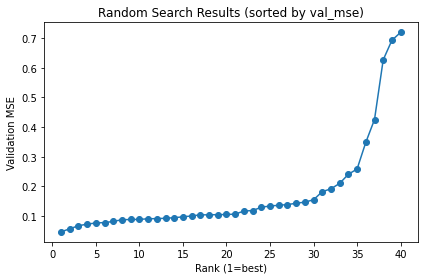

,trial,depth,width,activation,batchnorm,dropout,optimizer,learning_rate,batch_size,val_mse,val_mae
count,40.000000,40.000000,40.000000,40,40,40.000000,40,40.000000,40.000000,40.000000,40.000000
unique,NaN,NaN,NaN,4,2,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,gelu,True,NaN,rmsprop,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,13,21,NaN,15,NaN,NaN,NaN,NaN
mean,20.500000,3.375000,197.600000,NaN,NaN,0.222500,NaN,0.009215,160.000000,0.173785,0.295846
std,11.690452,1.705008,168.377598,NaN,NaN,0.181853,NaN,0.012485,86.958876,0.164636,0.110405
min,1.000000,1.000000,32.000000,NaN,NaN,0.000000,NaN,0.000106,64.000000,0.046711,0.180416
25%,10.750000,2.000000,64.000000,NaN,NaN,0.000000,NaN,0.000481,64.000000,0.090208,0.231965
50%,20.500000,3.000000,128.000000,NaN,NaN,0.250000,NaN,0.003266,128.000000,0.105815,0.256834
75%,30.250000,5.000000,256.000000,NaN,NaN,0.400000,NaN,0.015123,256.000000,0.161706,0.313543


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df.index+1, df["val_mse"], marker='o', linestyle='-')
plt.xlabel('Rank (1=best)')
plt.ylabel('Validation MSE')
plt.title('Random Search Results (sorted by val_mse)')
plt.tight_layout()
plt.show()

df.describe(include='all')

## 5. Select the Top-10 configurations
We extract the top-10 by validation MSE for a deeper retraining pass.

In [13]:
TOP_K = 5
topk = df.head(TOP_K).copy()
topk

,trial,depth,width,activation,batchnorm,dropout,optimizer,learning_rate,batch_size,val_mse,val_mae
0,37,1,128,relu,False,0.1,adam,0.009248,128,0.046711,0.180416
1,36,3,32,gelu,True,0.1,rmsprop,0.007025,64,0.056885,0.193722
2,9,6,128,elu,True,0.0,adam,0.001733,256,0.067345,0.205303
3,13,4,128,gelu,True,0.4,adam,0.002769,256,0.072618,0.213007
4,22,3,32,tanh,True,0.0,rmsprop,0.003763,64,0.076624,0.218028


## 6. Retrain Top-10 on Train+Val and Evaluate on Test
We join train and val, retrain each model for more epochs, and evaluate test performance. We also map predictions back to the original target scale for interpretability.

In [11]:
X_final = np.concatenate([X_train_s, X_val_s], axis=0)
y_final = np.concatenate([y_train_s, y_val_s], axis=0)

FINAL_EPOCHS = 40 # larger than origial 
final_records = []

for i, row in topk.iterrows():
    cfg = {k: row[k] for k in [
        "depth","width","activation","batchnorm","dropout","optimizer","learning_rate","batch_size"
    ]}
    model = build_model(cfg)
    early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(
        X_final, y_final,
        validation_data=(X_test_s, y_test_s),  # monitor generalization
        epochs=FINAL_EPOCHS,
        batch_size=cfg["batch_size"],
        verbose=0,
        callbacks=[early],
    )
    # Evaluate on test in standardized space
    test_mse, test_mae = model.evaluate(X_test_s, y_test_s, verbose=0)

    # Convert metrics to original y-scale
    # If y' = (y - mu)/sigma, then MSE_y = sigma^2 * MSE_y'
    sigma_y = float(y_scaler.scale_[0])
    test_rmse_orig = math.sqrt(test_mse) * sigma_y
    test_mae_orig  = test_mae * sigma_y

    final_records.append({
        **cfg,
        "test_mse_std": float(test_mse),
        "test_mae_std": float(test_mae),
        "test_rmse_orig": float(test_rmse_orig),
        "test_mae_orig": float(test_mae_orig),
    })

final_df = pd.DataFrame(final_records).sort_values("test_rmse_orig").reset_index(drop=True)
final_df.head(10)

,depth,width,activation,batchnorm,dropout,optimizer,learning_rate,batch_size,test_mse_std,test_mae_std,test_rmse_orig,test_mae_orig
0,1,128,relu,False,0.1,adam,0.009248,128,0.046349,0.175059,0.229041,0.186242
1,3,32,gelu,True,0.1,rmsprop,0.007025,64,0.059418,0.191880,0.259330,0.204139
2,6,128,elu,True,0.0,adam,0.001733,256,0.063105,0.197965,0.267255,0.210612
3,4,128,gelu,True,0.4,adam,0.002769,256,0.075190,0.204652,0.291726,0.217726
4,3,32,tanh,True,0.0,rmsprop,0.003763,64,0.080217,0.207794,0.301321,0.221069


### Compare Top-10 Test Performance
We show the distribution of test RMSE (original scale) across the top-10 models.

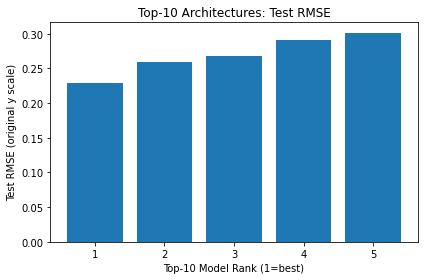

,depth,width,activation,batchnorm,dropout,optimizer,learning_rate,batch_size,test_mse_std,test_mae_std,test_rmse_orig,test_mae_orig
0,1,128,relu,False,0.1,adam,0.009248,128,0.046349,0.175059,0.229041,0.186242
1,3,32,gelu,True,0.1,rmsprop,0.007025,64,0.059418,0.191880,0.259330,0.204139
2,6,128,elu,True,0.0,adam,0.001733,256,0.063105,0.197965,0.267255,0.210612
3,4,128,gelu,True,0.4,adam,0.002769,256,0.075190,0.204652,0.291726,0.217726
4,3,32,tanh,True,0.0,rmsprop,0.003763,64,0.080217,0.207794,0.301321,0.221069


In [14]:
plt.figure(figsize=(6,4))
plt.bar(range(1, len(final_df)+1), final_df["test_rmse_orig"])  # no color specified per instructions
plt.xlabel('Top-10 Model Rank (1=best)')
plt.ylabel('Test RMSE (original y scale)')
plt.title('Top-10 Architectures: Test RMSE')
plt.tight_layout()
plt.show()

final_df

## 7. Introspection: What worked well?
We can check which hyperparameters appear in the winning models. This is not causal inference—just a quick descriptive analysis to support discussion during the lecture.

In [15]:
summary_cols = ["depth","width","activation","batchnorm","dropout","optimizer","batch_size"]
for col in summary_cols:
    display(final_df[col].value_counts())

depth
3    2
1    1
6    1
4    1
Name: count, dtype: int64

width
128    3
32     2
Name: count, dtype: int64

activation
gelu    2
relu    1
elu     1
tanh    1
Name: count, dtype: int64

batchnorm
True     4
False    1
Name: count, dtype: int64

dropout
0.1    2
0.0    2
0.4    1
Name: count, dtype: int64

optimizer
adam       3
rmsprop    2
Name: count, dtype: int64

batch_size
64     2
256    2
128    1
Name: count, dtype: int64

## 8. Save Artifacts (Optional)
We save the top-10 leaderboard and the full random-search table to CSV for later inspection. You can also save models if desired.

In [ ]:
os.makedirs("nas_outputs", exist_ok=True)
df.to_csv("nas_outputs/random_search_all_trials.csv", index=False)
final_df.to_csv("nas_outputs/top10_retrained_test_metrics.csv", index=False)
print("Saved:")
print(" - nas_outputs/random_search_all_trials.csv")
print(" - nas_outputs/top10_retrained_test_metrics.csv")

## 9. Teaching Notes & Extensions
- **Budget vs. space:** Increase `N_TRIALS` or `EPOCHS_PER_TRIAL` for better results; decrease for speed.
- **Early stopping:** Helps avoid wasted compute on poor configs.
- **Alternative strategies:**
  - *Successive Halving / Hyperband:* Train all a little, keep the best, allocate more epochs iteratively.
  - *Bayesian Optimization:* Use a surrogate model (e.g., Gaussian Process, TPE) to guide sampling.
  - *Evolutionary Algorithms:* Maintain a population of architectures, select/mutate/crossover.
- **Search space design:** Consider residual connections, per-layer activations, weight decay, spectral norm, etc.
- **Metrics:** We use MSE/MAE. For noisy targets, RMSE in original units (back-transformed) is easier to interpret.
- **Reproducibility:** Fix seeds, log versions, save artifacts, record configs for each trial.
- **Caveat:** Random Search is strong but not magic—if the space is huge and the budget is tiny, you may under-sample good regions.

---
**End of notebook.**